In [1]:
import ast
import gc
import glob
import json
import os
import shutil

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skimage
import torch
from IPython.core.interactiveshell import InteractiveShell
from sklearn.model_selection import GroupKFold, StratifiedGroupKFold
from tqdm import tqdm

InteractiveShell.ast_node_interactivity = "all"
import sys
from functools import partial

sys.path.append("/app/_data/MONAI")
import monai
from monai import data
from monai.data import decollate_batch
from monai.inferers import sliding_window_inference
from monai.losses import DiceLoss
from monai.metrics import CumulativeIterationMetric, DiceMetric
from monai.metrics.utils import (
    do_metric_reduction,
    get_mask_edges,
    get_surface_distance,
)
from monai.networks.nets import SwinUNETR, UNet
from monai.utils import LossReduction
from monai.utils.enums import MetricReduction

Extension horovod.torch has not been built: /usr/local/lib/python3.8/dist-packages/horovod/torch/mpi_lib/_mpi_lib.cpython-38-x86_64-linux-gnu.so not found
If this is not expected, reinstall Horovod with HOROVOD_WITH_PYTORCH=1 to debug the build error.
Warning! MPI libs are missing, but python applications are still available.


In [ ]:
!wandb login 2a29d4ea12edef115a98307eee0e9bf7db67b635

In [2]:
IMG_SIZE = (224, 224, 80)
BATCH_SIZE = 12

In [3]:
class DiceBceMultilabelLoss(torch.nn.modules.loss._Loss):
    def __init__(
        self,
        w_dice=0.7,
        w_bce=0.3,
        reduction=LossReduction.MEAN,
    ):
        super().__init__(reduction=LossReduction(reduction).value)
        self.w_dice = w_dice
        self.w_bce = w_bce
        self.dice_loss = monai.losses.DiceLoss( 
            sigmoid=True,   
            smooth_nr=0.001,
            smooth_dr=0.001,
            include_background=False,
            batch=True,
            squared_pred=False,
        )
        self.bce_loss = torch.nn.BCEWithLogitsLoss()

    def forward(self, pred, label):

        loss = (
            self.dice_loss(pred, label) * self.w_dice
            + self.bce_loss(pred, label) * self.w_bce
        )
        return loss


class HausdorffScore(CumulativeIterationMetric):
    """
    Modify MONAI's HausdorffDistanceMetric for Kaggle UW-Madison GI Tract Image Segmentation

    """

    def __init__(
        self,
        reduction="mean",
    ) -> None:
        super().__init__()
        self.reduction = reduction

    def _compute_tensor(self, pred, gt):

        return compute_hausdorff_score(pred, gt)

    def aggregate(self):
        """
        Execute reduction logic for the output of `compute_hausdorff_distance`.

        """
        data = self.get_buffer()
        # do metric reduction
        f, _ = do_metric_reduction(data, self.reduction)
        return f


def compute_directed_hausdorff(pred, gt, max_dist):
    if np.all(pred == gt):
        return 0.0
    if np.sum(pred) == 0:
        return 1.0
    if np.sum(gt) == 0:
        return 1.0
    (edges_pred, edges_gt) = get_mask_edges(pred, gt)
    surface_distance = get_surface_distance(
        edges_pred, edges_gt, distance_metric="euclidean"
    )
    if surface_distance.shape == (0,):
        return 0.0
    dist = surface_distance.max()

    if dist > max_dist:
        return 1.0
    return dist / max_dist


def compute_hausdorff_score(pred, gt):

    y = gt.float().to("cpu").numpy()
    y_pred = pred.float().to("cpu").numpy()

    # hausdorff distance score
    batch_size, n_class = y_pred.shape[:2]
    spatial_size = y_pred.shape[2:]
    max_dist = np.sqrt(np.sum([l**2 for l in spatial_size]))
    hd_score = np.empty((batch_size, n_class))
    for b, c in np.ndindex(batch_size, n_class):
        hd_score[b, c] = 1 - compute_directed_hausdorff(y_pred[b, c], y[b, c], max_dist)

    return torch.from_numpy(hd_score)

In [4]:
df = pd.read_csv("/app/data_3d_info.csv")
FOLD = 2
train_df = df[df["fold"] != FOLD]
val_df = df[df["fold"] == FOLD]
train_data = [
    {"image": x, "label": y} for x, y in train_df[["image_path", "mask_path"]].values
]
val_data = [{"image": x, "label": y} for x, y in val_df[["image_path", "mask_path"]].values]

In [5]:
train_transforms = monai.transforms.Compose(
    [
        monai.transforms.LoadImaged(
            keys=["image", "label"],
        ),
        monai.transforms.AddChanneld(keys="image"),
        monai.transforms.Transposed(
            keys="label", indices=[3, 0, 1, 2]
        ),  # h, w, d, c to c, h, w, d
        monai.transforms.RandSpatialCropd(
            keys=("image", "label"),
            roi_size=IMG_SIZE,
            random_size=False,
        ),
        monai.transforms.RandFlipd(
            keys=["image", "label"],
            spatial_axis=[0],
            prob=0.10,
        ),
        monai.transforms.RandFlipd(
            keys=["image", "label"],
            spatial_axis=[1],
            prob=0.10,
        ),
        monai.transforms.RandRotate90d(
            keys=["image", "label"],
            prob=0.10,
            max_k=3,
        ),
        monai.transforms.RandShiftIntensityd(
            keys=["image"],
            offsets=0.10,
            prob=0.50,
        ),
        monai.transforms.OneOf(
            [
                monai.transforms.RandGridDistortiond(
                    keys=["image", "label"],
                    prob=0.2,
                    distort_limit=(-0.05, 0.05),
                    mode="nearest",
                    padding_mode="zeros",
                ),
                monai.transforms.RandAffined(
                    keys=["image", "label"],
                    prob=0.2,
                    rotate_range=np.pi / 12,
                    translate_range=(IMG_SIZE[0] * 0.0625, IMG_SIZE[0] * 0.0625),
                    scale_range=(0.1, 0.1),
                    mode="nearest",
                    padding_mode="zeros",
                ),
            ],
        ),
        monai.transforms.Lambdad(
            keys="image", func=lambda x: x / x.max()
        ),  # normalize to [0, 1] range
        monai.transforms.EnsureTyped(keys=["image", "label"], dtype=torch.float32),
    ]
)

val_transforms = monai.transforms.Compose(
    [
        monai.transforms.LoadImaged(
            keys=["image", "label"],
        ),
        monai.transforms.AddChanneld(keys="image"),
        monai.transforms.Transposed(
            keys="label", indices=[3, 0, 1, 2]
        ),  # h, w, d, c to c, h, w, d
        monai.transforms.Lambdad(
            keys="image", func=lambda x: x / x.max()
        ),  # normalize to [0, 1] range
        monai.transforms.EnsureTyped(keys=["image", "label"], dtype=torch.float32),
    ]
)

In [6]:
train_ds = monai.data.CacheDataset(
    data=train_data,
    transform=train_transforms,
    cache_num=32,
    cache_rate=1.0,
    num_workers=None,
)
val_ds = monai.data.CacheDataset(
    data=val_data,
    transform=val_transforms,
    cache_num=32,
    cache_rate=1.0,
    num_workers=None,
)

Loading dataset: 100% 32/32 [00:22<00:00,  1.41it/s]
Loading dataset: 100% 32/32 [00:20<00:00,  1.59it/s]


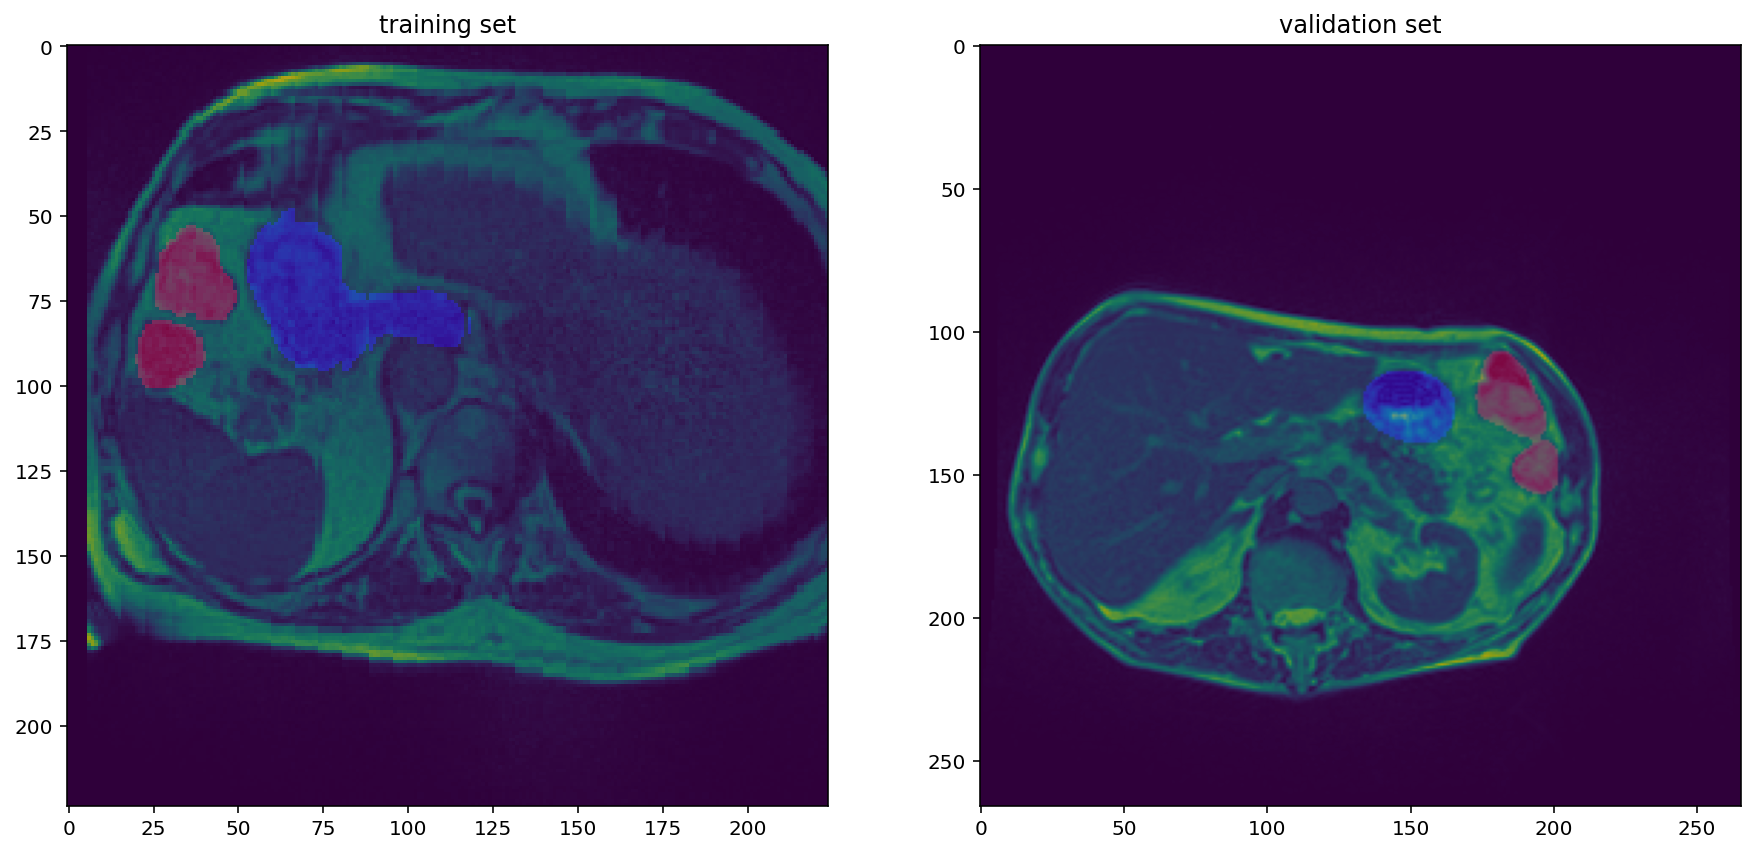

In [7]:
ix, i = 2, 49
img = train_ds[ix]
plt.figure(figsize=(15, 7))
plt.subplot(1,2,1)
plt.title('training set')
plt.imshow(img["image"].numpy()[0, :, :, i])
plt.imshow(img["label"].numpy()[:, :, :, i].transpose(1, 2, 0), alpha=0.3)
ix, i = 2, 75
img = val_ds[ix]
plt.subplot(1,2,2)
plt.title('validation set')
plt.imshow(img["image"].numpy()[0, :, :, i])
plt.imshow(img["label"].numpy()[:, :, :, i].transpose(1, 2, 0), alpha=0.3)
plt.show();

In [8]:
train_loader = monai.data.DataLoader(
    train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True
)
val_loader = monai.data.DataLoader(
    val_ds, batch_size=1, shuffle=False, num_workers=0, pin_memory=True
)

## model

In [9]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=3,
    channels=(32, 64, 128, 256, 512),
    strides=(2, 2, 2, 2),
    kernel_size=3,
    up_kernel_size=3,
    num_res_units=2,
    act="PRELU",
    norm="Batch",
    dropout=0.1,
    bias=True,
    dimensions=None,
).to(device)


torch.backends.cudnn.benchmark = True

In [11]:
model.load_state_dict(torch.load("/app/_data/3Dmodels/unet_224_80/last.pth"))

In [12]:
loss_fn = DiceBceMultilabelLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=200,
    eta_min=0.00001,
)
dice_metric = monai.metrics.DiceMetric(
    include_background=False, reduction="mean", ignore_empty=False
)
hausdorff_metric = HausdorffScore(reduction="mean")

In [13]:
def train_one_epoch(model, train_loader, optimizer, scheduler, device, loss_fn, epoch):
    model.train()
    running_loss = 0
    train_bar = tqdm(
        enumerate(train_loader),
        total=len(train_loader),
        desc=f"Train: epoch #{epoch + 1}",
        dynamic_ncols=True,
    )
    for step, batch in train_bar:
        step += 1
        optimizer.zero_grad()
        x, y = batch["image"].to(device), batch["label"].to(device)
        logits = model(x)
        loss = loss_fn(logits, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        current_lr = optimizer.param_groups[0]["lr"]
        memory = torch.cuda.memory_reserved() / 1e9 if torch.cuda.is_available() else 0
        train_bar.set_postfix(
            train_loss=f"{running_loss/step:0.4f}",
            lr=f"{current_lr:0.6f}",
            gpu_memory=f"{memory:0.2f} GB",
        )
    scheduler.step()
    torch.cuda.empty_cache()
    gc.collect()
    return running_loss / step

In [14]:
def validate(model, val_loader, device, epoch, img_size, batch_size):
    post_pred = monai.transforms.Compose(
        [
            monai.transforms.Activations(sigmoid=True),
            monai.transforms.AsDiscrete(threshold=0.5),
        ]
    )
    dice = 0
    hd = 0
    weightad_score = 0
    model.eval()

    val_bar = tqdm(
        enumerate(val_loader),
        total=len(val_loader),
        desc=f"Val:   epoch #{epoch + 1}",
    )

    for step, batch in val_bar:
        val_inputs, val_labels = batch["image"].to(device), batch["label"].to(device)
        with torch.no_grad():
            val_outputs = sliding_window_inference(val_inputs, img_size, 1, model)
        val_outputs = [post_pred(i) for i in val_outputs]
        val_outputs = torch.stack(val_outputs)
        # metric is slice level put (n, c, h, w, d) to (n, d, c, h, w) to (n*d, c, h, w)
        val_outputs = val_outputs.permute([0, 4, 1, 2, 3]).flatten(0, 1)
        val_labels = val_labels.permute([0, 4, 1, 2, 3]).flatten(0, 1)
        hausdorff_metric(y_pred=val_outputs, y=val_labels)
        dice_metric(y_pred=val_outputs, y=val_labels)
        del val_outputs, val_inputs, val_labels, batch
    dice_score = dice_metric.aggregate().item()
    hausdorff_score = hausdorff_metric.aggregate().item()
    dice_metric.reset()
    hausdorff_metric.reset()
    all_score = dice_score * 0.4 + hausdorff_score * 0.6
    print(
        f"dice_score: {dice_score} hausdorff_score: {hausdorff_score} all_score: {all_score}"
    )
    torch.cuda.empty_cache()
    gc.collect()
    return dice_score, hausdorff_score, all_score

In [ ]:
n_epoch = 1000
best_dice = 0
best_cum_metric = 0
best_epoch = 0
path = "/app/_data/3Dmodels/unet_224_80_f2"
os.makedirs(path, exist_ok=True)
scores = {"train_loss": [], "dice": [], "hd": [], "mean_score": []}
for epoch in range(n_epoch):
    epoch_loss = train_one_epoch(
        model, train_loader, optimizer, scheduler, device, loss_fn, epoch
    )
    scores["train_loss"].append(epoch_loss)
    torch.save(model.state_dict(), os.path.join(path, "last.pth"))

    dice_score, hausdorff_score, all_score = validate(
        model, val_loader, device, epoch, img_size=IMG_SIZE, batch_size = BATCH_SIZE
    )
    scores["dice"].append(dice_score)
    scores["hd"].append(hausdorff_score)
    scores["mean_score"].append(all_score)
    if dice_score > best_dice:
        best_epoch = epoch
        torch.save(model.state_dict(), os.path.join(path, "best_dice.pth"))
        print(
            f"Dice improved from {best_dice:0.4f} to {dice_score:0.4f}, model was saved at {os.path.join(path, 'best_dice.pth')}"
        )
        best_dice = dice_score
    if all_score > best_cum_metric:
        best_epoch = epoch
        torch.save(model.state_dict(), os.path.join(path, "best_all.pth"))
        print(
            f"best_cum_metric improved from {best_cum_metric:0.4f} to {all_score:0.4f}, model was saved at {os.path.join(path, 'best_all.pth')}"
        )
        best_cum_metric = all_score
    torch.save(model.state_dict(), os.path.join(path, "last.pth"))

Train: epoch #1: 100% 20/20 [03:35<00:00, 10.76s/it, gpu_memory=4.15 GB, lr=0.001000, train_loss=0.9207] 
Val:   epoch #1: 100% 40/40 [01:28<00:00,  2.22s/it]


dice_score: 0.00975155271589756 hausdorff_score: 0.15114920442877922 all_score: 0.09459014374362655
Dice improved from 0.0000 to 0.0098, model was saved at /app/_data/3Dmodels/unet_224_80_f2/best_dice.pth
best_cum_metric improved from 0.0000 to 0.0946, model was saved at /app/_data/3Dmodels/unet_224_80_f2/best_all.pth


Train: epoch #2: 100% 20/20 [03:23<00:00, 10.16s/it, gpu_memory=22.68 GB, lr=0.001000, train_loss=0.8886]
Val:   epoch #2: 100% 40/40 [01:24<00:00,  2.11s/it]


dice_score: 0.11108561605215073 hausdorff_score: 0.2311900000629076 all_score: 0.18314824645860486
Dice improved from 0.0098 to 0.1111, model was saved at /app/_data/3Dmodels/unet_224_80_f2/best_dice.pth
best_cum_metric improved from 0.0946 to 0.1831, model was saved at /app/_data/3Dmodels/unet_224_80_f2/best_all.pth


Train: epoch #3: 100% 20/20 [03:23<00:00, 10.16s/it, gpu_memory=22.68 GB, lr=0.001000, train_loss=0.8457]
Val:   epoch #3: 100% 40/40 [01:17<00:00,  1.94s/it]


dice_score: 0.18420441448688507 hausdorff_score: 0.33406029868714154 all_score: 0.27411794500703895
Dice improved from 0.1111 to 0.1842, model was saved at /app/_data/3Dmodels/unet_224_80_f2/best_dice.pth
best_cum_metric improved from 0.1831 to 0.2741, model was saved at /app/_data/3Dmodels/unet_224_80_f2/best_all.pth


Train: epoch #4: 100% 20/20 [03:19<00:00,  9.98s/it, gpu_memory=22.68 GB, lr=0.000999, train_loss=0.7922]
Val:   epoch #4: 100% 40/40 [00:59<00:00,  1.49s/it]


dice_score: 0.2680171728134155 hausdorff_score: 0.49495041165104814 all_score: 0.40417711611599505
Dice improved from 0.1842 to 0.2680, model was saved at /app/_data/3Dmodels/unet_224_80_f2/best_dice.pth
best_cum_metric improved from 0.2741 to 0.4042, model was saved at /app/_data/3Dmodels/unet_224_80_f2/best_all.pth


Train: epoch #5: 100% 20/20 [03:17<00:00,  9.86s/it, gpu_memory=22.68 GB, lr=0.000999, train_loss=0.7366]
Val:   epoch #5: 100% 40/40 [00:48<00:00,  1.21s/it]


dice_score: 0.48039111495018005 hausdorff_score: 0.6429839012022286 all_score: 0.5779467867014092
Dice improved from 0.2680 to 0.4804, model was saved at /app/_data/3Dmodels/unet_224_80_f2/best_dice.pth
best_cum_metric improved from 0.4042 to 0.5779, model was saved at /app/_data/3Dmodels/unet_224_80_f2/best_all.pth


Train: epoch #6: 100% 20/20 [03:17<00:00,  9.88s/it, gpu_memory=22.68 GB, lr=0.000998, train_loss=0.6997]
Val:   epoch #6: 100% 40/40 [00:58<00:00,  1.47s/it]


dice_score: 0.4173732101917267 hausdorff_score: 0.5847466976002822 all_score: 0.51779730263686


Train: epoch #7: 100% 20/20 [03:13<00:00,  9.67s/it, gpu_memory=22.68 GB, lr=0.000998, train_loss=0.6650]
Val:   epoch #7: 100% 40/40 [00:59<00:00,  1.48s/it]


dice_score: 0.4389192759990692 hausdorff_score: 0.5734158790855256 all_score: 0.519617237850943


Train: epoch #8: 100% 20/20 [03:07<00:00,  9.37s/it, gpu_memory=22.68 GB, lr=0.000997, train_loss=0.6307]
Val:   epoch #8: 100% 40/40 [01:00<00:00,  1.50s/it]


dice_score: 0.3310309946537018 hausdorff_score: 0.48142416351568434 all_score: 0.4212668959708913


Train: epoch #9: 100% 20/20 [03:11<00:00,  9.59s/it, gpu_memory=22.68 GB, lr=0.000996, train_loss=0.5986]
Val:   epoch #9: 100% 40/40 [00:51<00:00,  1.28s/it]


dice_score: 0.5468446016311646 hausdorff_score: 0.6531773601302695 all_score: 0.6106442567306275
Dice improved from 0.4804 to 0.5468, model was saved at /app/_data/3Dmodels/unet_224_80_f2/best_dice.pth
best_cum_metric improved from 0.5779 to 0.6106, model was saved at /app/_data/3Dmodels/unet_224_80_f2/best_all.pth


Train: epoch #10: 100% 20/20 [03:11<00:00,  9.55s/it, gpu_memory=22.68 GB, lr=0.000995, train_loss=0.5844]
Val:   epoch #10: 100% 40/40 [00:36<00:00,  1.09it/s]


dice_score: 0.6969484090805054 hausdorff_score: 0.7179443085601392 all_score: 0.7095459487682857
Dice improved from 0.5468 to 0.6969, model was saved at /app/_data/3Dmodels/unet_224_80_f2/best_dice.pth
best_cum_metric improved from 0.6106 to 0.7095, model was saved at /app/_data/3Dmodels/unet_224_80_f2/best_all.pth


Train: epoch #11: 100% 20/20 [03:02<00:00,  9.14s/it, gpu_memory=22.68 GB, lr=0.000994, train_loss=0.5568]
Val:   epoch #11: 100% 40/40 [00:56<00:00,  1.41s/it]


dice_score: 0.4523817002773285 hausdorff_score: 0.5788301149407071 all_score: 0.5282507490753556


Train: epoch #12: 100% 20/20 [03:06<00:00,  9.34s/it, gpu_memory=22.68 GB, lr=0.000993, train_loss=0.5618]
Val:   epoch #12: 100% 40/40 [00:59<00:00,  1.49s/it]


dice_score: 0.3162243962287903 hausdorff_score: 0.46455557142303894 all_score: 0.40522310134533945


Train: epoch #13: 100% 20/20 [03:17<00:00,  9.86s/it, gpu_memory=22.68 GB, lr=0.000991, train_loss=0.5560]
Val:   epoch #13: 100% 40/40 [00:53<00:00,  1.34s/it]


dice_score: 0.5469832420349121 hausdorff_score: 0.6648490841910881 all_score: 0.6177027473286177


Train: epoch #14: 100% 20/20 [03:12<00:00,  9.60s/it, gpu_memory=22.68 GB, lr=0.000990, train_loss=0.5470]
Val:   epoch #14: 100% 40/40 [00:51<00:00,  1.29s/it]


dice_score: 0.6122328639030457 hausdorff_score: 0.7310854694171958 all_score: 0.6835444272115357


Train: epoch #15: 100% 20/20 [03:10<00:00,  9.51s/it, gpu_memory=22.68 GB, lr=0.000988, train_loss=0.5322]
Val:   epoch #15: 100% 40/40 [00:52<00:00,  1.32s/it]


dice_score: 0.5879653096199036 hausdorff_score: 0.7182740410465821 all_score: 0.6661505484759107


Train: epoch #16: 100% 20/20 [03:07<00:00,  9.35s/it, gpu_memory=22.68 GB, lr=0.000986, train_loss=0.5278]
Val:   epoch #16: 100% 40/40 [00:51<00:00,  1.30s/it]


dice_score: 0.5879338979721069 hausdorff_score: 0.6926777752023041 all_score: 0.6507802243102252


Train: epoch #17: 100% 20/20 [03:12<00:00,  9.63s/it, gpu_memory=22.68 GB, lr=0.000984, train_loss=0.5229]
Val:   epoch #17: 100% 40/40 [00:52<00:00,  1.30s/it]


dice_score: 0.6219016909599304 hausdorff_score: 0.7397044604842706 all_score: 0.6925833526745345


Train: epoch #18: 100% 20/20 [03:12<00:00,  9.60s/it, gpu_memory=22.68 GB, lr=0.000982, train_loss=0.5252]
Val:   epoch #18: 100% 40/40 [00:32<00:00,  1.22it/s]


dice_score: 0.7301445007324219 hausdorff_score: 0.6939228685675849 all_score: 0.7084115214335196
Dice improved from 0.6969 to 0.7301, model was saved at /app/_data/3Dmodels/unet_224_80_f2/best_dice.pth


Train: epoch #19: 100% 20/20 [03:14<00:00,  9.72s/it, gpu_memory=22.68 GB, lr=0.000980, train_loss=0.5047]
Val:   epoch #19: 100% 40/40 [00:58<00:00,  1.47s/it]


dice_score: 0.5015546083450317 hausdorff_score: 0.6390813712003567 all_score: 0.5840706660582267


Train: epoch #20: 100% 20/20 [03:07<00:00,  9.39s/it, gpu_memory=22.68 GB, lr=0.000978, train_loss=0.4975]
Val:   epoch #20: 100% 40/40 [00:39<00:00,  1.01it/s]


dice_score: 0.7064436674118042 hausdorff_score: 0.7441190321729418 all_score: 0.7290488862684867
best_cum_metric improved from 0.7095 to 0.7290, model was saved at /app/_data/3Dmodels/unet_224_80_f2/best_all.pth


Train: epoch #21: 100% 20/20 [03:08<00:00,  9.43s/it, gpu_memory=22.68 GB, lr=0.000976, train_loss=0.4721]
Val:   epoch #21: 100% 40/40 [00:42<00:00,  1.06s/it]


dice_score: 0.7166211605072021 hausdorff_score: 0.7629678740692734 all_score: 0.7444291886444449
best_cum_metric improved from 0.7290 to 0.7444, model was saved at /app/_data/3Dmodels/unet_224_80_f2/best_all.pth


Train: epoch #22: 100% 20/20 [03:04<00:00,  9.20s/it, gpu_memory=22.68 GB, lr=0.000973, train_loss=0.4528]
Val:   epoch #22: 100% 40/40 [00:59<00:00,  1.48s/it]


dice_score: 0.5534458756446838 hausdorff_score: 0.6838748761721456 all_score: 0.6317032759611609


Train: epoch #23: 100% 20/20 [03:05<00:00,  9.26s/it, gpu_memory=22.68 GB, lr=0.000971, train_loss=0.4171]
Val:   epoch #23: 100% 40/40 [00:34<00:00,  1.14it/s]


dice_score: 0.7327691316604614 hausdorff_score: 0.7233829245062429 all_score: 0.7271374073679303
Dice improved from 0.7301 to 0.7328, model was saved at /app/_data/3Dmodels/unet_224_80_f2/best_dice.pth


Train: epoch #24: 100% 20/20 [03:06<00:00,  9.35s/it, gpu_memory=22.68 GB, lr=0.000968, train_loss=0.3979]
Val:   epoch #24: 100% 40/40 [00:38<00:00,  1.04it/s]


dice_score: 0.7459829449653625 hausdorff_score: 0.7270292663669307 all_score: 0.7346107378063034
Dice improved from 0.7328 to 0.7460, model was saved at /app/_data/3Dmodels/unet_224_80_f2/best_dice.pth


Train: epoch #25: 100% 20/20 [03:15<00:00,  9.79s/it, gpu_memory=22.68 GB, lr=0.000965, train_loss=0.3926]
Val:   epoch #25: 100% 40/40 [00:54<00:00,  1.37s/it]


dice_score: 0.7127405405044556 hausdorff_score: 0.792563763214801 all_score: 0.7606344741306628
best_cum_metric improved from 0.7444 to 0.7606, model was saved at /app/_data/3Dmodels/unet_224_80_f2/best_all.pth


Train: epoch #26: 100% 20/20 [03:11<00:00,  9.57s/it, gpu_memory=22.68 GB, lr=0.000962, train_loss=0.3782]
Val:   epoch #26: 100% 40/40 [01:01<00:00,  1.54s/it]


dice_score: 0.5464155673980713 hausdorff_score: 0.6686684438196995 all_score: 0.6197672932510482


Train: epoch #27: 100% 20/20 [03:13<00:00,  9.66s/it, gpu_memory=22.68 GB, lr=0.000959, train_loss=0.3667]
Val:   epoch #27: 100% 40/40 [00:45<00:00,  1.14s/it]


dice_score: 0.7714657187461853 hausdorff_score: 0.7982079408524029 all_score: 0.7875110520099159
Dice improved from 0.7460 to 0.7715, model was saved at /app/_data/3Dmodels/unet_224_80_f2/best_dice.pth
best_cum_metric improved from 0.7606 to 0.7875, model was saved at /app/_data/3Dmodels/unet_224_80_f2/best_all.pth


Train: epoch #28: 100% 20/20 [03:12<00:00,  9.65s/it, gpu_memory=22.68 GB, lr=0.000956, train_loss=0.3511]
Val:   epoch #28: 100% 40/40 [00:55<00:00,  1.39s/it]


dice_score: 0.7363762855529785 hausdorff_score: 0.8107469084026119 all_score: 0.7809986592627585


Train: epoch #29: 100% 20/20 [03:13<00:00,  9.69s/it, gpu_memory=22.68 GB, lr=0.000953, train_loss=0.3588]
Val:   epoch #29: 100% 40/40 [00:49<00:00,  1.23s/it]


dice_score: 0.7721367478370667 hausdorff_score: 0.8137805890719672 all_score: 0.7971230525780069
Dice improved from 0.7715 to 0.7721, model was saved at /app/_data/3Dmodels/unet_224_80_f2/best_dice.pth
best_cum_metric improved from 0.7875 to 0.7971, model was saved at /app/_data/3Dmodels/unet_224_80_f2/best_all.pth


Train: epoch #30: 100% 20/20 [03:11<00:00,  9.57s/it, gpu_memory=22.68 GB, lr=0.000950, train_loss=0.3260]
Val:   epoch #30: 100% 40/40 [00:42<00:00,  1.07s/it]


dice_score: 0.7784410715103149 hausdorff_score: 0.7808513271399542 all_score: 0.7798872248880986
Dice improved from 0.7721 to 0.7784, model was saved at /app/_data/3Dmodels/unet_224_80_f2/best_dice.pth


Train: epoch #31: 100% 20/20 [03:15<00:00,  9.79s/it, gpu_memory=22.68 GB, lr=0.000946, train_loss=0.3211]
Val:   epoch #31: 100% 40/40 [00:56<00:00,  1.40s/it]


dice_score: 0.7561615109443665 hausdorff_score: 0.8257958182342274 all_score: 0.797942095318283
best_cum_metric improved from 0.7971 to 0.7979, model was saved at /app/_data/3Dmodels/unet_224_80_f2/best_all.pth


Train: epoch #32: 100% 20/20 [03:14<00:00,  9.71s/it, gpu_memory=22.68 GB, lr=0.000942, train_loss=0.3287]
Val:   epoch #32: 100% 40/40 [00:57<00:00,  1.44s/it]


dice_score: 0.6234157681465149 hausdorff_score: 0.7342943574691668 all_score: 0.6899429217401061


Train: epoch #33: 100% 20/20 [03:14<00:00,  9.72s/it, gpu_memory=22.68 GB, lr=0.000939, train_loss=0.3205]
Val:   epoch #33: 100% 40/40 [00:51<00:00,  1.29s/it]


dice_score: 0.812873899936676 hausdorff_score: 0.8325382209197361 all_score: 0.8246724925265121
Dice improved from 0.7784 to 0.8129, model was saved at /app/_data/3Dmodels/unet_224_80_f2/best_dice.pth
best_cum_metric improved from 0.7979 to 0.8247, model was saved at /app/_data/3Dmodels/unet_224_80_f2/best_all.pth


Train: epoch #34: 100% 20/20 [03:12<00:00,  9.64s/it, gpu_memory=22.68 GB, lr=0.000935, train_loss=0.3088]
Val:   epoch #34: 100% 40/40 [00:44<00:00,  1.11s/it]


dice_score: 0.7919175028800964 hausdorff_score: 0.7970741669529111 all_score: 0.7950115013237853


Train: epoch #35: 100% 20/20 [03:10<00:00,  9.55s/it, gpu_memory=22.68 GB, lr=0.000931, train_loss=0.3090]
Val:   epoch #35: 100% 40/40 [01:00<00:00,  1.51s/it]


dice_score: 0.4554717540740967 hausdorff_score: 0.6136600278041834 all_score: 0.5503847183121486


Train: epoch #36: 100% 20/20 [03:14<00:00,  9.70s/it, gpu_memory=22.68 GB, lr=0.000927, train_loss=0.3016]
Val:   epoch #36: 100% 40/40 [00:53<00:00,  1.33s/it]


dice_score: 0.8129386305809021 hausdorff_score: 0.8315547294544888 all_score: 0.8241082899050541
Dice improved from 0.8129 to 0.8129, model was saved at /app/_data/3Dmodels/unet_224_80_f2/best_dice.pth


Train: epoch #37: 100% 20/20 [03:13<00:00,  9.67s/it, gpu_memory=22.68 GB, lr=0.000923, train_loss=0.2935]
Val:   epoch #37: 100% 40/40 [00:45<00:00,  1.14s/it]


dice_score: 0.8011696338653564 hausdorff_score: 0.800091168952475 all_score: 0.8005225549176276


Train: epoch #38: 100% 20/20 [03:11<00:00,  9.58s/it, gpu_memory=22.68 GB, lr=0.000919, train_loss=0.2825]
Val:   epoch #38: 100% 40/40 [00:43<00:00,  1.08s/it]


dice_score: 0.7965760231018066 hausdorff_score: 0.7881220100316547 all_score: 0.7915036152597155


Train: epoch #39: 100% 20/20 [03:13<00:00,  9.67s/it, gpu_memory=22.68 GB, lr=0.000914, train_loss=0.2943]
Val:   epoch #39: 100% 40/40 [00:57<00:00,  1.43s/it]


dice_score: 0.6591297388076782 hausdorff_score: 0.7577852768924916 all_score: 0.7183230616585663


Train: epoch #40: 100% 20/20 [03:16<00:00,  9.82s/it, gpu_memory=22.68 GB, lr=0.000910, train_loss=0.2702]
Val:   epoch #40: 100% 40/40 [00:51<00:00,  1.30s/it]


dice_score: 0.8108410239219666 hausdorff_score: 0.8288155224105456 all_score: 0.8216257230151139


Train: epoch #41: 100% 20/20 [03:18<00:00,  9.93s/it, gpu_memory=22.68 GB, lr=0.000905, train_loss=0.2664]
Val:   epoch #41: 100% 40/40 [00:48<00:00,  1.21s/it]


dice_score: 0.8183518052101135 hausdorff_score: 0.8165167900992575 all_score: 0.8172507961435999
Dice improved from 0.8129 to 0.8184, model was saved at /app/_data/3Dmodels/unet_224_80_f2/best_dice.pth


Train: epoch #42: 100% 20/20 [03:13<00:00,  9.66s/it, gpu_memory=22.68 GB, lr=0.000901, train_loss=0.2742]
Val:   epoch #42: 100% 40/40 [00:49<00:00,  1.24s/it]


dice_score: 0.8029505014419556 hausdorff_score: 0.8095144576126352 all_score: 0.8068888751443634


Train: epoch #43: 100% 20/20 [03:18<00:00,  9.92s/it, gpu_memory=22.68 GB, lr=0.000896, train_loss=0.2595]
Val:   epoch #43: 100% 40/40 [00:50<00:00,  1.26s/it]


dice_score: 0.829620897769928 hausdorff_score: 0.8348878446065721 all_score: 0.8327810658719144
Dice improved from 0.8184 to 0.8296, model was saved at /app/_data/3Dmodels/unet_224_80_f2/best_dice.pth
best_cum_metric improved from 0.8247 to 0.8328, model was saved at /app/_data/3Dmodels/unet_224_80_f2/best_all.pth


Train: epoch #44: 100% 20/20 [03:13<00:00,  9.69s/it, gpu_memory=22.68 GB, lr=0.000891, train_loss=0.2677]
Val:   epoch #44: 100% 40/40 [00:47<00:00,  1.18s/it]


dice_score: 0.8186372518539429 hausdorff_score: 0.8207368456888638 all_score: 0.8198970081548955


Train: epoch #45: 100% 20/20 [03:13<00:00,  9.65s/it, gpu_memory=22.68 GB, lr=0.000886, train_loss=0.2430]
Val:   epoch #45: 100% 40/40 [00:51<00:00,  1.28s/it]


dice_score: 0.8032874464988708 hausdorff_score: 0.8118585178356055 all_score: 0.8084300893009116


Train: epoch #46: 100% 20/20 [03:13<00:00,  9.67s/it, gpu_memory=22.68 GB, lr=0.000881, train_loss=0.2393]
Val:   epoch #46: 100% 40/40 [00:52<00:00,  1.32s/it]


dice_score: 0.7929031848907471 hausdorff_score: 0.8134774347165651 all_score: 0.8052477347862379


Train: epoch #47: 100% 20/20 [03:16<00:00,  9.84s/it, gpu_memory=22.68 GB, lr=0.000876, train_loss=0.2620]
Val:   epoch #47: 100% 40/40 [00:54<00:00,  1.36s/it]


dice_score: 0.8478204607963562 hausdorff_score: 0.8612110804370475 all_score: 0.855854832580771
Dice improved from 0.8296 to 0.8478, model was saved at /app/_data/3Dmodels/unet_224_80_f2/best_dice.pth
best_cum_metric improved from 0.8328 to 0.8559, model was saved at /app/_data/3Dmodels/unet_224_80_f2/best_all.pth


Train: epoch #48: 100% 20/20 [03:13<00:00,  9.67s/it, gpu_memory=22.68 GB, lr=0.000871, train_loss=0.2410]
Val:   epoch #48: 100% 40/40 [00:51<00:00,  1.28s/it]


dice_score: 0.8286802768707275 hausdorff_score: 0.8289883542153114 all_score: 0.8288651232774777


Train: epoch #49: 100% 20/20 [03:14<00:00,  9.74s/it, gpu_memory=22.68 GB, lr=0.000866, train_loss=0.2393]
Val:   epoch #49: 100% 40/40 [00:52<00:00,  1.30s/it]


dice_score: 0.8082782626152039 hausdorff_score: 0.8157728550901124 all_score: 0.812775018100149


Train: epoch #50: 100% 20/20 [03:11<00:00,  9.60s/it, gpu_memory=22.68 GB, lr=0.000860, train_loss=0.2378]
Val:   epoch #50: 100% 40/40 [00:52<00:00,  1.32s/it]


dice_score: 0.7815184593200684 hausdorff_score: 0.8199233481557165 all_score: 0.8045613926214572


Train: epoch #51: 100% 20/20 [03:16<00:00,  9.81s/it, gpu_memory=22.68 GB, lr=0.000855, train_loss=0.2387]
Val:   epoch #51: 100% 40/40 [00:51<00:00,  1.30s/it]


dice_score: 0.8560398817062378 hausdorff_score: 0.8415480799442876 all_score: 0.8473448006490677
Dice improved from 0.8478 to 0.8560, model was saved at /app/_data/3Dmodels/unet_224_80_f2/best_dice.pth


Train: epoch #52: 100% 20/20 [03:12<00:00,  9.60s/it, gpu_memory=22.68 GB, lr=0.000849, train_loss=0.2268]
Val:   epoch #52: 100% 40/40 [00:49<00:00,  1.25s/it]


dice_score: 0.8502644300460815 hausdorff_score: 0.8392795462415127 all_score: 0.8436734997633402


Train: epoch #53: 100% 20/20 [03:14<00:00,  9.71s/it, gpu_memory=22.68 GB, lr=0.000844, train_loss=0.2300]
Val:   epoch #53: 100% 40/40 [00:48<00:00,  1.22s/it]


dice_score: 0.854510486125946 hausdorff_score: 0.8287296177153011 all_score: 0.8390419650795591


Train: epoch #54: 100% 20/20 [03:15<00:00,  9.75s/it, gpu_memory=22.68 GB, lr=0.000838, train_loss=0.2252]
Val:   epoch #54: 100% 40/40 [00:48<00:00,  1.21s/it]


dice_score: 0.844805896282196 hausdorff_score: 0.8264008580014718 all_score: 0.8337628733137614


Train: epoch #55: 100% 20/20 [03:10<00:00,  9.52s/it, gpu_memory=22.68 GB, lr=0.000832, train_loss=0.2205]
Val:   epoch #55: 100% 40/40 [00:47<00:00,  1.20s/it]


dice_score: 0.8388735055923462 hausdorff_score: 0.8244996591953737 all_score: 0.8302491977541627


Train: epoch #56: 100% 20/20 [03:09<00:00,  9.48s/it, gpu_memory=22.68 GB, lr=0.000826, train_loss=0.2126]
Val:   epoch #56: 100% 40/40 [00:49<00:00,  1.25s/it]


dice_score: 0.8196563720703125 hausdorff_score: 0.804537244212375 all_score: 0.8105848953555501


Train: epoch #57: 100% 20/20 [03:12<00:00,  9.63s/it, gpu_memory=22.68 GB, lr=0.000821, train_loss=0.2171]
Val:   epoch #57: 100% 40/40 [00:51<00:00,  1.29s/it]


dice_score: 0.8556253910064697 hausdorff_score: 0.8308658320760153 all_score: 0.8407696556481971


Train: epoch #58: 100% 20/20 [03:16<00:00,  9.84s/it, gpu_memory=22.68 GB, lr=0.000814, train_loss=0.2074]
Val:   epoch #58: 100% 40/40 [00:50<00:00,  1.25s/it]


dice_score: 0.8658716678619385 hausdorff_score: 0.8324341592842808 all_score: 0.8458091627153439
Dice improved from 0.8560 to 0.8659, model was saved at /app/_data/3Dmodels/unet_224_80_f2/best_dice.pth


Train: epoch #59: 100% 20/20 [03:16<00:00,  9.82s/it, gpu_memory=22.68 GB, lr=0.000808, train_loss=0.2078]
Val:   epoch #59: 100% 40/40 [00:49<00:00,  1.24s/it]


dice_score: 0.8620100021362305 hausdorff_score: 0.8353010673863084 all_score: 0.8459846412862773


Train: epoch #60: 100% 20/20 [03:17<00:00,  9.90s/it, gpu_memory=22.68 GB, lr=0.000802, train_loss=0.2138]
Val:   epoch #60: 100% 40/40 [00:52<00:00,  1.30s/it]


dice_score: 0.8310964107513428 hausdorff_score: 0.8211340871085133 all_score: 0.8251190165656451


Train: epoch #61: 100% 20/20 [03:17<00:00,  9.87s/it, gpu_memory=22.68 GB, lr=0.000796, train_loss=0.2071]
Val:   epoch #61: 100% 40/40 [00:49<00:00,  1.24s/it]


dice_score: 0.8489739894866943 hausdorff_score: 0.8344166790415822 all_score: 0.8402396032196271


Train: epoch #62: 100% 20/20 [03:19<00:00,  9.97s/it, gpu_memory=22.68 GB, lr=0.000790, train_loss=0.2015]
Val:   epoch #62: 100% 40/40 [00:54<00:00,  1.37s/it]


dice_score: 0.8563287258148193 hausdorff_score: 0.8601079961551968 all_score: 0.8585962880190459
best_cum_metric improved from 0.8559 to 0.8586, model was saved at /app/_data/3Dmodels/unet_224_80_f2/best_all.pth


Train: epoch #63: 100% 20/20 [03:16<00:00,  9.81s/it, gpu_memory=22.68 GB, lr=0.000783, train_loss=0.1965]
Val:   epoch #63: 100% 40/40 [00:54<00:00,  1.37s/it]


dice_score: 0.8059412837028503 hausdorff_score: 0.822495862328779 all_score: 0.8158740308784076


Train: epoch #64: 100% 20/20 [03:19<00:00,  9.97s/it, gpu_memory=22.68 GB, lr=0.000777, train_loss=0.1981]
Val:   epoch #64: 100% 40/40 [00:53<00:00,  1.33s/it]


dice_score: 0.8665882349014282 hausdorff_score: 0.8655348553920341 all_score: 0.8659562071957918
Dice improved from 0.8659 to 0.8666, model was saved at /app/_data/3Dmodels/unet_224_80_f2/best_dice.pth
best_cum_metric improved from 0.8586 to 0.8660, model was saved at /app/_data/3Dmodels/unet_224_80_f2/best_all.pth


Train: epoch #65: 100% 20/20 [03:16<00:00,  9.82s/it, gpu_memory=22.68 GB, lr=0.000770, train_loss=0.1954]
Val:   epoch #65: 100% 40/40 [00:59<00:00,  1.48s/it]


dice_score: 0.8708381056785583 hausdorff_score: 0.8762019537769866 all_score: 0.8740564145376153
Dice improved from 0.8666 to 0.8708, model was saved at /app/_data/3Dmodels/unet_224_80_f2/best_dice.pth
best_cum_metric improved from 0.8660 to 0.8741, model was saved at /app/_data/3Dmodels/unet_224_80_f2/best_all.pth


Train: epoch #66: 100% 20/20 [03:13<00:00,  9.70s/it, gpu_memory=22.68 GB, lr=0.000764, train_loss=0.1975]
Val:   epoch #66: 100% 40/40 [00:52<00:00,  1.31s/it]


dice_score: 0.867993175983429 hausdorff_score: 0.8818445405428211 all_score: 0.8763039947190643
best_cum_metric improved from 0.8741 to 0.8763, model was saved at /app/_data/3Dmodels/unet_224_80_f2/best_all.pth


Train: epoch #67: 100% 20/20 [03:17<00:00,  9.87s/it, gpu_memory=22.68 GB, lr=0.000757, train_loss=0.2001]
Val:   epoch #67: 100% 40/40 [00:59<00:00,  1.48s/it]


dice_score: 0.8610243797302246 hausdorff_score: 0.9052527280083636 all_score: 0.8875613886971081
best_cum_metric improved from 0.8763 to 0.8876, model was saved at /app/_data/3Dmodels/unet_224_80_f2/best_all.pth


Train: epoch #68: 100% 20/20 [03:20<00:00, 10.03s/it, gpu_memory=22.68 GB, lr=0.000750, train_loss=0.1996]
Val:   epoch #68: 100% 40/40 [00:56<00:00,  1.42s/it]


dice_score: 0.8684915900230408 hausdorff_score: 0.904662031266271 all_score: 0.8901938547689789
best_cum_metric improved from 0.8876 to 0.8902, model was saved at /app/_data/3Dmodels/unet_224_80_f2/best_all.pth


Train: epoch #69: 100% 20/20 [03:16<00:00,  9.81s/it, gpu_memory=22.68 GB, lr=0.000743, train_loss=0.1902]
Val:   epoch #69: 100% 40/40 [01:00<00:00,  1.50s/it]


dice_score: 0.8734357953071594 hausdorff_score: 0.9163379285919909 all_score: 0.8991770752780583
Dice improved from 0.8708 to 0.8734, model was saved at /app/_data/3Dmodels/unet_224_80_f2/best_dice.pth
best_cum_metric improved from 0.8902 to 0.8992, model was saved at /app/_data/3Dmodels/unet_224_80_f2/best_all.pth


Train: epoch #70: 100% 20/20 [03:16<00:00,  9.82s/it, gpu_memory=22.68 GB, lr=0.000737, train_loss=0.1913]
Val:   epoch #70: 100% 40/40 [01:03<00:00,  1.58s/it]


dice_score: 0.8234530687332153 hausdorff_score: 0.7672565357633083 all_score: 0.7897351489512712


Train: epoch #71: 100% 20/20 [03:17<00:00,  9.86s/it, gpu_memory=22.68 GB, lr=0.000730, train_loss=0.1852]
Val:   epoch #71: 100% 40/40 [01:02<00:00,  1.56s/it]


dice_score: 0.8445035219192505 hausdorff_score: 0.8503928726587616 all_score: 0.8480371323629572


Train: epoch #72: 100% 20/20 [03:21<00:00, 10.06s/it, gpu_memory=22.68 GB, lr=0.000723, train_loss=0.1939]
Val:   epoch #72: 100% 40/40 [01:03<00:00,  1.58s/it]


dice_score: 0.8536953330039978 hausdorff_score: 0.888718874556752 all_score: 0.8747094579356504


Train: epoch #73: 100% 20/20 [03:14<00:00,  9.71s/it, gpu_memory=22.68 GB, lr=0.000716, train_loss=0.1792]
Val:   epoch #73: 100% 40/40 [01:03<00:00,  1.60s/it]


dice_score: 0.7760611176490784 hausdorff_score: 0.8000145526871927 all_score: 0.790433178671947


Train: epoch #74: 100% 20/20 [03:14<00:00,  9.71s/it, gpu_memory=22.68 GB, lr=0.000709, train_loss=0.1812]
Val:   epoch #74: 100% 40/40 [00:59<00:00,  1.48s/it]


dice_score: 0.869598388671875 hausdorff_score: 0.9127511079437385 all_score: 0.895490020234993


Train: epoch #75: 100% 20/20 [03:13<00:00,  9.66s/it, gpu_memory=22.68 GB, lr=0.000702, train_loss=0.1832]
Val:   epoch #75: 100% 40/40 [01:00<00:00,  1.50s/it]


dice_score: 0.8711015582084656 hausdorff_score: 0.9122264484303345 all_score: 0.895776492341587


Train: epoch #76: 100% 20/20 [03:16<00:00,  9.81s/it, gpu_memory=22.68 GB, lr=0.000694, train_loss=0.1806]
Val:   epoch #76: 100% 40/40 [01:00<00:00,  1.51s/it]


dice_score: 0.8535516262054443 hausdorff_score: 0.8641562901505252 all_score: 0.8599144245724928


Train: epoch #77: 100% 20/20 [03:13<00:00,  9.68s/it, gpu_memory=22.68 GB, lr=0.000687, train_loss=0.1811]
Val:   epoch #77: 100% 40/40 [00:59<00:00,  1.50s/it]


dice_score: 0.8717763423919678 hausdorff_score: 0.8983040252331581 all_score: 0.887692952096682


Train: epoch #78: 100% 20/20 [03:15<00:00,  9.79s/it, gpu_memory=22.68 GB, lr=0.000680, train_loss=0.1743]
Val:   epoch #78: 100% 40/40 [01:01<00:00,  1.54s/it]


dice_score: 0.8679512143135071 hausdorff_score: 0.8813374550684522 all_score: 0.8759829587664741


Train: epoch #79: 100% 20/20 [03:13<00:00,  9.68s/it, gpu_memory=22.68 GB, lr=0.000673, train_loss=0.1768]
Val:   epoch #79: 100% 40/40 [01:12<00:00,  1.80s/it]


dice_score: 0.8762393593788147 hausdorff_score: 0.8559780724564955 all_score: 0.8640825872254232
Dice improved from 0.8734 to 0.8762, model was saved at /app/_data/3Dmodels/unet_224_80_f2/best_dice.pth


Train: epoch #80: 100% 20/20 [03:13<00:00,  9.65s/it, gpu_memory=22.68 GB, lr=0.000665, train_loss=0.1738]
Val:   epoch #80: 100% 40/40 [01:02<00:00,  1.57s/it]


dice_score: 0.8343376517295837 hausdorff_score: 0.8119434967567751 all_score: 0.8209011587458985


Train: epoch #81: 100% 20/20 [03:23<00:00, 10.19s/it, gpu_memory=22.68 GB, lr=0.000658, train_loss=0.1748]
Val:   epoch #81: 100% 40/40 [00:59<00:00,  1.49s/it]


dice_score: 0.8631303310394287 hausdorff_score: 0.9077357264785376 all_score: 0.8898935683028941


Train: epoch #82: 100% 20/20 [03:10<00:00,  9.51s/it, gpu_memory=22.68 GB, lr=0.000651, train_loss=0.1648]
Val:   epoch #82: 100% 40/40 [00:59<00:00,  1.49s/it]


dice_score: 0.8708309531211853 hausdorff_score: 0.9002752361676163 all_score: 0.8884975229490439


Train: epoch #83: 100% 20/20 [03:12<00:00,  9.61s/it, gpu_memory=22.68 GB, lr=0.000643, train_loss=0.1738]
Val:   epoch #83: 100% 40/40 [00:59<00:00,  1.50s/it]


dice_score: 0.8823534846305847 hausdorff_score: 0.9092883065920501 all_score: 0.8985143778074639
Dice improved from 0.8762 to 0.8824, model was saved at /app/_data/3Dmodels/unet_224_80_f2/best_dice.pth


Train: epoch #84: 100% 20/20 [03:21<00:00, 10.08s/it, gpu_memory=22.68 GB, lr=0.000636, train_loss=0.1686]
Val:   epoch #84: 100% 40/40 [01:03<00:00,  1.60s/it]


dice_score: 0.8878871202468872 hausdorff_score: 0.9148314705489933 all_score: 0.9040537304281508
Dice improved from 0.8824 to 0.8879, model was saved at /app/_data/3Dmodels/unet_224_80_f2/best_dice.pth
best_cum_metric improved from 0.8992 to 0.9041, model was saved at /app/_data/3Dmodels/unet_224_80_f2/best_all.pth


Train: epoch #85: 100% 20/20 [03:12<00:00,  9.61s/it, gpu_memory=22.68 GB, lr=0.000628, train_loss=0.1657]
Val:   epoch #85: 100% 40/40 [01:03<00:00,  1.60s/it]


dice_score: 0.8868598937988281 hausdorff_score: 0.8932541366541662 all_score: 0.8906964395120309


Train: epoch #86: 100% 20/20 [03:11<00:00,  9.56s/it, gpu_memory=22.68 GB, lr=0.000621, train_loss=0.1590]
Val:   epoch #86: 100% 40/40 [01:03<00:00,  1.58s/it]


dice_score: 0.8926897048950195 hausdorff_score: 0.8786794420473083 all_score: 0.8842835471863928
Dice improved from 0.8879 to 0.8927, model was saved at /app/_data/3Dmodels/unet_224_80_f2/best_dice.pth


Train: epoch #87: 100% 20/20 [03:21<00:00, 10.09s/it, gpu_memory=22.68 GB, lr=0.000613, train_loss=0.1593]
Val:   epoch #87: 100% 40/40 [01:02<00:00,  1.55s/it]


dice_score: 0.8825207352638245 hausdorff_score: 0.9193910047288089 all_score: 0.9046428969428151
best_cum_metric improved from 0.9041 to 0.9046, model was saved at /app/_data/3Dmodels/unet_224_80_f2/best_all.pth


Train: epoch #88: 100% 20/20 [03:18<00:00,  9.94s/it, gpu_memory=22.68 GB, lr=0.000605, train_loss=0.1592]
Val:   epoch #88: 100% 40/40 [01:05<00:00,  1.65s/it]


dice_score: 0.8583645224571228 hausdorff_score: 0.7931767925948439 all_score: 0.8192518845397554


Train: epoch #89: 100% 20/20 [03:19<00:00,  9.95s/it, gpu_memory=22.68 GB, lr=0.000598, train_loss=0.1642]
Val:   epoch #89: 100% 40/40 [01:00<00:00,  1.51s/it]


dice_score: 0.8861875534057617 hausdorff_score: 0.9229367992063261 all_score: 0.9082371008861003
best_cum_metric improved from 0.9046 to 0.9082, model was saved at /app/_data/3Dmodels/unet_224_80_f2/best_all.pth


Train: epoch #90: 100% 20/20 [03:13<00:00,  9.67s/it, gpu_memory=22.68 GB, lr=0.000590, train_loss=0.1677]
Val:   epoch #90: 100% 40/40 [01:02<00:00,  1.56s/it]


dice_score: 0.8810120224952698 hausdorff_score: 0.8988412304161475 all_score: 0.8917095472477965


Train: epoch #91: 100% 20/20 [03:13<00:00,  9.67s/it, gpu_memory=22.68 GB, lr=0.000582, train_loss=0.1584]
Val:   epoch #91: 100% 40/40 [01:00<00:00,  1.50s/it]


dice_score: 0.8822004795074463 hausdorff_score: 0.9314658331390961 all_score: 0.9117596916864361
best_cum_metric improved from 0.9082 to 0.9118, model was saved at /app/_data/3Dmodels/unet_224_80_f2/best_all.pth


Train: epoch #92: 100% 20/20 [03:13<00:00,  9.67s/it, gpu_memory=22.68 GB, lr=0.000575, train_loss=0.1548]
Val:   epoch #92: 100% 40/40 [01:01<00:00,  1.54s/it]


dice_score: 0.889642059803009 hausdorff_score: 0.8934413334018412 all_score: 0.8919216239623083


Train: epoch #93: 100% 20/20 [03:14<00:00,  9.72s/it, gpu_memory=22.68 GB, lr=0.000567, train_loss=0.1548]
Val:   epoch #93: 100% 40/40 [01:00<00:00,  1.52s/it]


dice_score: 0.8847352862358093 hausdorff_score: 0.8976796378280326 all_score: 0.8925018971911433


Train: epoch #94: 100% 20/20 [03:10<00:00,  9.54s/it, gpu_memory=22.68 GB, lr=0.000559, train_loss=0.1579]
Val:   epoch #94: 100% 40/40 [01:00<00:00,  1.52s/it]


dice_score: 0.880084216594696 hausdorff_score: 0.8751516613169403 all_score: 0.8771246834280426


Train: epoch #95: 100% 20/20 [03:18<00:00,  9.92s/it, gpu_memory=22.68 GB, lr=0.000552, train_loss=0.1571]
Val:   epoch #95: 100% 40/40 [01:02<00:00,  1.56s/it]


dice_score: 0.8851948976516724 hausdorff_score: 0.8853522093537038 all_score: 0.8852892846728913


Train: epoch #96: 100% 20/20 [03:13<00:00,  9.69s/it, gpu_memory=22.68 GB, lr=0.000544, train_loss=0.1590]
Val:   epoch #96: 100% 40/40 [01:01<00:00,  1.53s/it]


dice_score: 0.8935392498970032 hausdorff_score: 0.9194734024536155 all_score: 0.9090997414309706
Dice improved from 0.8927 to 0.8935, model was saved at /app/_data/3Dmodels/unet_224_80_f2/best_dice.pth


Train: epoch #97: 100% 20/20 [03:18<00:00,  9.90s/it, gpu_memory=22.68 GB, lr=0.000536, train_loss=0.1520]
Val:   epoch #97: 100% 40/40 [01:01<00:00,  1.54s/it]


dice_score: 0.8789939880371094 hausdorff_score: 0.8694869606887634 all_score: 0.8732897716281018


Train: epoch #98: 100% 20/20 [03:12<00:00,  9.62s/it, gpu_memory=22.68 GB, lr=0.000528, train_loss=0.1506]
Val:   epoch #98: 100% 40/40 [01:00<00:00,  1.51s/it]


dice_score: 0.8988010287284851 hausdorff_score: 0.8562394724630699 all_score: 0.8732640949692361
Dice improved from 0.8935 to 0.8988, model was saved at /app/_data/3Dmodels/unet_224_80_f2/best_dice.pth


Train: epoch #99: 100% 20/20 [03:13<00:00,  9.69s/it, gpu_memory=22.68 GB, lr=0.000521, train_loss=0.1537]
Val:   epoch #99: 100% 40/40 [01:01<00:00,  1.55s/it]


dice_score: 0.878948986530304 hausdorff_score: 0.9115344089972502 all_score: 0.8985002400104718


Train: epoch #100: 100% 20/20 [03:13<00:00,  9.68s/it, gpu_memory=22.68 GB, lr=0.000513, train_loss=0.1500]
Val:   epoch #100: 100% 40/40 [01:02<00:00,  1.55s/it]


dice_score: 0.8873190879821777 hausdorff_score: 0.886004639397619 all_score: 0.8865304188314425


Train: epoch #101: 100% 20/20 [03:13<00:00,  9.66s/it, gpu_memory=22.68 GB, lr=0.000505, train_loss=0.1526]
Val:   epoch #101: 100% 40/40 [01:01<00:00,  1.55s/it]


dice_score: 0.8790231943130493 hausdorff_score: 0.8850386132695133 all_score: 0.8826324456869277


Train: epoch #102: 100% 20/20 [03:16<00:00,  9.81s/it, gpu_memory=22.68 GB, lr=0.000497, train_loss=0.1492]
Val:   epoch #102: 100% 40/40 [01:01<00:00,  1.55s/it]


dice_score: 0.8817456364631653 hausdorff_score: 0.8845238241590154 all_score: 0.8834125490806753


Train: epoch #103: 100% 20/20 [03:08<00:00,  9.43s/it, gpu_memory=22.68 GB, lr=0.000489, train_loss=0.1501]
Val:   epoch #103: 100% 40/40 [01:03<00:00,  1.58s/it]


dice_score: 0.8840577006340027 hausdorff_score: 0.9043683876639773 all_score: 0.8962441128519875


Train: epoch #104: 100% 20/20 [03:13<00:00,  9.68s/it, gpu_memory=22.68 GB, lr=0.000482, train_loss=0.1425]
Val:   epoch #104: 100% 40/40 [01:00<00:00,  1.52s/it]


dice_score: 0.8920324444770813 hausdorff_score: 0.9057239760274347 all_score: 0.9002473634072934


Train: epoch #105: 100% 20/20 [03:13<00:00,  9.69s/it, gpu_memory=22.68 GB, lr=0.000474, train_loss=0.1469]
Val:   epoch #105: 100% 40/40 [01:01<00:00,  1.55s/it]


dice_score: 0.8944963216781616 hausdorff_score: 0.9170912595822629 all_score: 0.9080532844206224


Train: epoch #106: 100% 20/20 [03:15<00:00,  9.80s/it, gpu_memory=22.68 GB, lr=0.000466, train_loss=0.1450]
Val:   epoch #106: 100% 40/40 [01:01<00:00,  1.53s/it]


dice_score: 0.8991367220878601 hausdorff_score: 0.904955369622941 all_score: 0.9026279106089087
Dice improved from 0.8988 to 0.8991, model was saved at /app/_data/3Dmodels/unet_224_80_f2/best_dice.pth


Train: epoch #107: 100% 20/20 [03:17<00:00,  9.85s/it, gpu_memory=22.68 GB, lr=0.000458, train_loss=0.1425]
Val:   epoch #107: 100% 40/40 [01:02<00:00,  1.55s/it]


dice_score: 0.8882222771644592 hausdorff_score: 0.8750660590496865 all_score: 0.8803285462955956


Train: epoch #108: 100% 20/20 [03:18<00:00,  9.95s/it, gpu_memory=22.68 GB, lr=0.000451, train_loss=0.1410]
Val:   epoch #108: 100% 40/40 [01:01<00:00,  1.53s/it]


dice_score: 0.8965168595314026 hausdorff_score: 0.9223694897811349 all_score: 0.912028437681242
best_cum_metric improved from 0.9118 to 0.9120, model was saved at /app/_data/3Dmodels/unet_224_80_f2/best_all.pth


Train: epoch #109: 100% 20/20 [03:10<00:00,  9.52s/it, gpu_memory=22.68 GB, lr=0.000443, train_loss=0.1383]
Val:   epoch #109: 100% 40/40 [01:01<00:00,  1.54s/it]


dice_score: 0.8997352123260498 hausdorff_score: 0.9209715927491128 all_score: 0.9124770405798877
Dice improved from 0.8991 to 0.8997, model was saved at /app/_data/3Dmodels/unet_224_80_f2/best_dice.pth
best_cum_metric improved from 0.9120 to 0.9125, model was saved at /app/_data/3Dmodels/unet_224_80_f2/best_all.pth


Train: epoch #110: 100% 20/20 [03:16<00:00,  9.83s/it, gpu_memory=22.68 GB, lr=0.000435, train_loss=0.1397]
Val:   epoch #110: 100% 40/40 [01:01<00:00,  1.53s/it]


dice_score: 0.8965750336647034 hausdorff_score: 0.9353789590760837 all_score: 0.9198573889115316
best_cum_metric improved from 0.9125 to 0.9199, model was saved at /app/_data/3Dmodels/unet_224_80_f2/best_all.pth


Train: epoch #111: 100% 20/20 [03:15<00:00,  9.78s/it, gpu_memory=22.68 GB, lr=0.000428, train_loss=0.1388]
Val:   epoch #111: 100% 40/40 [01:06<00:00,  1.66s/it]


dice_score: 0.9016245603561401 hausdorff_score: 0.9191590007688027 all_score: 0.9121452246037377
Dice improved from 0.8997 to 0.9016, model was saved at /app/_data/3Dmodels/unet_224_80_f2/best_dice.pth


Train: epoch #112: 100% 20/20 [03:23<00:00, 10.15s/it, gpu_memory=22.68 GB, lr=0.000420, train_loss=0.1396]
Val:   epoch #112: 100% 40/40 [01:09<00:00,  1.73s/it]


dice_score: 0.8896057605743408 hausdorff_score: 0.9237398864314749 all_score: 0.9100862360886213


Train: epoch #113: 100% 20/20 [03:17<00:00,  9.86s/it, gpu_memory=22.68 GB, lr=0.000412, train_loss=0.1450]
Val:   epoch #113: 100% 40/40 [01:02<00:00,  1.55s/it]


dice_score: 0.8638976216316223 hausdorff_score: 0.8412223770767759 all_score: 0.8502924748987145


Train: epoch #114: 100% 20/20 [03:16<00:00,  9.81s/it, gpu_memory=22.68 GB, lr=0.000405, train_loss=0.1417]
Val:   epoch #114: 100% 40/40 [01:03<00:00,  1.59s/it]


dice_score: 0.8984135389328003 hausdorff_score: 0.9259012671248428 all_score: 0.9149061758480257


Train: epoch #115: 100% 20/20 [03:11<00:00,  9.59s/it, gpu_memory=22.68 GB, lr=0.000397, train_loss=0.1414]
Val:   epoch #115: 100% 40/40 [01:00<00:00,  1.52s/it]


dice_score: 0.8984892964363098 hausdorff_score: 0.926524816571962 all_score: 0.9153106085177012


Train: epoch #116: 100% 20/20 [03:19<00:00, 10.00s/it, gpu_memory=22.68 GB, lr=0.000389, train_loss=0.1356]
Val:   epoch #116: 100% 40/40 [01:08<00:00,  1.70s/it]


dice_score: 0.8947229385375977 hausdorff_score: 0.92611321405253 all_score: 0.9135571038465571


Train: epoch #117: 100% 20/20 [03:23<00:00, 10.17s/it, gpu_memory=22.68 GB, lr=0.000382, train_loss=0.1390]
Val:   epoch #117: 100% 40/40 [01:08<00:00,  1.70s/it]


dice_score: 0.8958532810211182 hausdorff_score: 0.8126224336491357 all_score: 0.8459147725979287


Train: epoch #118: 100% 20/20 [03:19<00:00,  9.96s/it, gpu_memory=22.68 GB, lr=0.000374, train_loss=0.1320]
Val:   epoch #118: 100% 40/40 [01:02<00:00,  1.57s/it]


dice_score: 0.8979584574699402 hausdorff_score: 0.9312595570884641 all_score: 0.9179391172410545


Train: epoch #119: 100% 20/20 [03:22<00:00, 10.12s/it, gpu_memory=22.68 GB, lr=0.000367, train_loss=0.1307]
Val:   epoch #119: 100% 40/40 [01:01<00:00,  1.53s/it]


dice_score: 0.8943465352058411 hausdorff_score: 0.8750138595626636 all_score: 0.8827469298199346


Train: epoch #120:  70% 14/20 [02:20<01:01, 10.29s/it, gpu_memory=22.68 GB, lr=0.000359, train_loss=0.1338]

In [16]:
best_cum_metric
best_dice

0.9245455211399698

0.9016245603561401

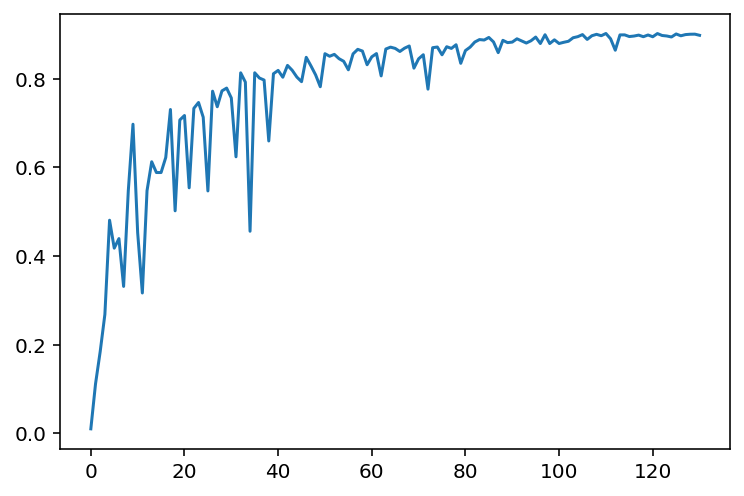

In [17]:
plt.plot(scores['dice'])

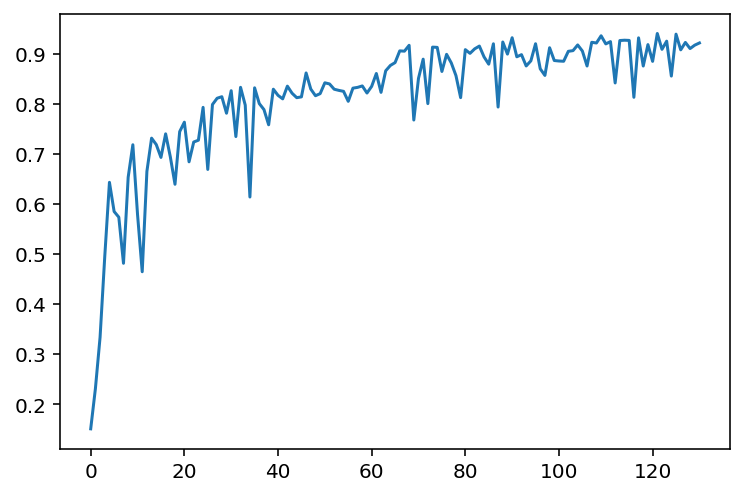

In [18]:
plt.plot(scores['hd'])

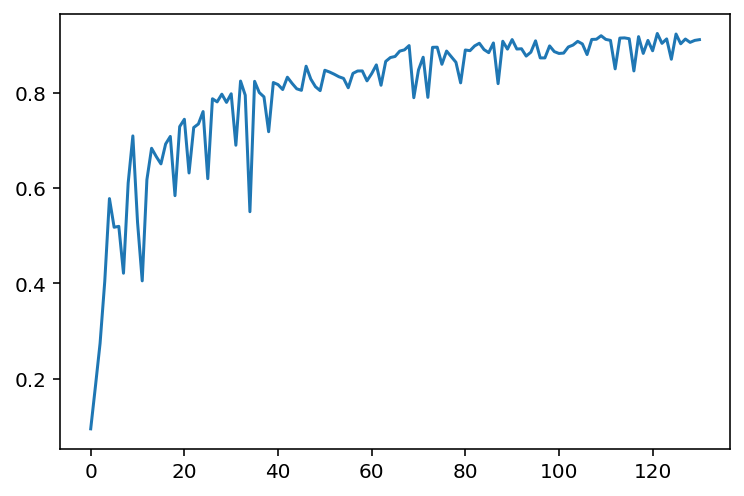

In [19]:
plt.plot(scores['mean_score'])

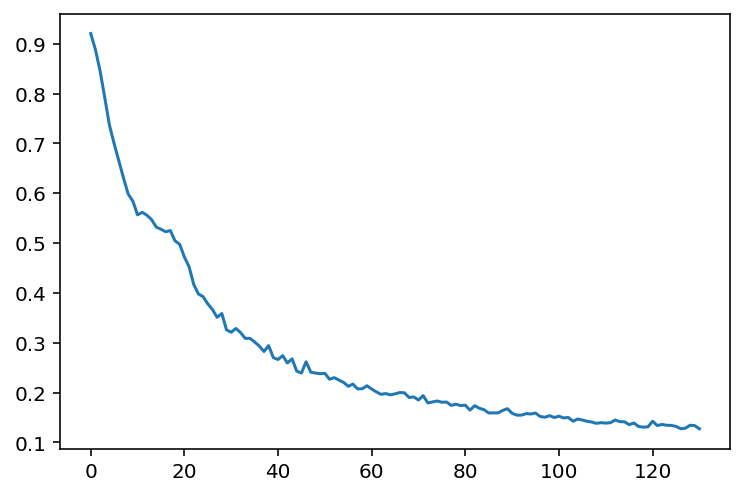

In [20]:
plt.plot(scores['train_loss'])